In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import random

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.utils import resample                      # Fare splitting
from sklearn.model_selection import validation_curve

# CLASSIFICAZIONE *RIADMISSION IN 365 DAYS*

In [3]:
df1 = pd.read_csv("df1.csv")

dato che bisogna predire la riammissione entro 365 giorni, vado ad eliminare tutte le feature riguardanti
riammissioni e e il campo della morte

In [4]:
remove_for_r365 = [
'death',
'riad 90d',
'riad 30d', 
'riad +365d',
]

In [5]:
remove_for_r365

['death', 'riad 90d', 'riad 30d', 'riad +365d']

In [6]:
df1.drop(remove_for_r365, axis=1, inplace=True)

In [7]:
df1

,gender,age,riad 365d,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
0,1,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
1,0,52,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,0,1
2,0,52,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
3,0,52,0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
4,0,52,0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521105,0,46,0,1.0,4.0,0.0,0.0,0.0,1.0,2.0,...,0,0,0,0,1,0,1,0,1,0
521106,0,48,0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
521107,1,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1
521108,1,58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,1


## creo training set, validation set, test set

In [8]:
train, validate, test = np.split(df1.sample(frac=1, random_state=42), [int(.6*len(df1)), int(.7*len(df1))])

## separo le label dai predittori

In [9]:
X_train_r365 = train.drop(["riad 365d"], axis=1)

In [10]:
y_train_r365 = train["riad 365d"]

In [11]:
X_validate_r365 = validate.drop(["riad 365d"], axis=1)

In [12]:
y_validate_r365 = validate["riad 365d"]

In [13]:
X_test_r365 = test.drop(["riad 365d"], axis=1)

In [14]:
y_test_r365 = test["riad 365d"]

controllo che la stratificazione in base alla label sia andata a buon fine:

In [15]:
# proporzione di classi positive (death 1) nel training set
tot_pos_train = len(y_train_r365[y_train_r365 == 1])
prop_pos_train = tot_pos_train / len(y_train_r365) * 100

print('{} % di riammessi entro 365 giorni nel training set'.format(prop_pos_train))
print('{} % di non riammessi entro 365 giorni nel training set'.format(100 - prop_pos_train))

print()

# proporzione di classi negative (death 0) nel validate set
tot_pos_validate = len(y_validate_r365[y_validate_r365 == 1])
prop_pos_validate = tot_pos_validate / len(y_validate_r365) * 100

print('{} % di riammessi entro 365 giorni nel validate set'.format(prop_pos_validate))
print('{} % non di riammessi entro 365 giorni nel validate set'.format(100 - prop_pos_validate))

print()

# proporzione di classi negative (death 0) nel testing set
tot_pos_test = len(y_test_r365[y_test_r365 == 1])
prop_pos_test = tot_pos_test / len(y_test_r365) * 100

print('{} % di riammessi entro 365 giorni ospedaliere nel testing set'.format(prop_pos_test))
print('{} % di non riammessi entro 365 giorni nel testing set'.format(100 - prop_pos_test))

11.520920087249653 % di riammessi entro 365 giorni nel training set
88.47907991275035 % di non riammessi entro 365 giorni nel training set

11.414096831762969 % di riammessi entro 365 giorni nel validate set
88.58590316823702 % non di riammessi entro 365 giorni nel validate set

11.429448676862851 % di riammessi entro 365 giorni ospedaliere nel testing set
88.57055132313715 % di non riammessi entro 365 giorni nel testing set


### standardizzo le features che hanno diverse scale di valori

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_r365_scaled = scaler.fit_transform(X_train_r365)  # fitting and transforming training set
X_train_r365_scaled

array([[-0.96512577, -0.75686884,  0.96630854, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.69621419, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.04036543, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [-0.96512577, -0.5656737 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [ 1.03613439,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577, -1.17749813,  2.44962278, ..., -0.87579316,
         1.20438887, -0.32124958]])

## Modelli di classificazione

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [18]:
models = [SGDClassifier, DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]
names = ['SGD Classifier', 'Decision Tree Classifier', 'RandomForestClassifier', 'Logistic Regressor']

In [19]:
from sklearn.metrics import accuracy_score

for i in range(len(models)):
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    model.fit(X_train_r365_scaled, y_train_r365) # qui addestro il modello sui dati
    y_pred_r365 = model.predict(X_train_r365_scaled)
    print(f'accuracy of {name}: ',accuracy_score(y_pred_r365, y_train_r365))

accuracy of SGD Classifier:  0.8847907991275035
accuracy of Decision Tree Classifier:  0.9978539399870788
accuracy of RandomForestClassifier:  0.997834750180704
accuracy of Logistic Regressor:  0.8847907991275035


anche nella predizione delle riammissioni entro 365 giorni otteniamo apparentemente delle prestazioni elevate ma siamo sempre di fronte  aun dataset sbilanciato

## cross validation

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


names_cv = ['sgd_cv', 'dt_cv', 'rf_cv', 'lr_cv']

for i in range(len(models)):
    avg_acc_models = []
    model = models[i](random_state=42)  # inizializzo il modello qui (non ancora addestrato)
    name = names[i] 
    acc_model = cross_val_score(model, X_train_r365_scaled, y_train_r365, cv=3, scoring='accuracy')
    avg_acc_model = acc_model.mean()
    avg_acc_models.append(avg_acc_model)
    print(f'accuracy of {name}: ', avg_acc_model)

accuracy of SGD Classifier:  0.8847907991275035
accuracy of Decision Tree Classifier:  0.7947330378103151
accuracy of RandomForestClassifier:  0.882689515329457
accuracy of Logistic Regressor:  0.8847907991275035


## analisi sui singoli modelli: SGD, DT, RF, LR
procedo ad analizzarli uno per uno esaminando le predizioni fatte tramite cross validation\
questa volta utilizzo *5-fold cross validation* per ogni modello

In [21]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

### analisi specifica su SGD Classifier

In [22]:
sgd_cv = SGDClassifier(random_state=42)
y_pred_sgd_cv = cross_val_predict(sgd_cv, X_train_r365_scaled, y_train_r365, cv=5)
score_sgd_cv = accuracy_score(y_train_r365, y_pred_sgd_cv)

In [23]:
list(y_pred_sgd_cv).count(1)  # numero di predizioni di riammissioni entro 365 giorni

0

In [24]:
score_sgd_cv

0.8847907991275035

### confusion matrix SGD

In [25]:
cm_r365_sgd = confusion_matrix(y_train_r365, y_pred_sgd_cv)
cm_r365_sgd

array([[276644,      0],
       [ 36022,      0]], dtype=int64)

In [26]:
print("PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r365_sgd[1,1]))
print("{} veri negativi".format(cm_r365_sgd[0,0]))
print("{} falsi positivi".format(cm_r365_sgd[0,1]))
print("{} falsi negativi".format(cm_r365_sgd[1,0]))

PREDIZIONI STOCHASTIC GRADIENT DESCENT CON CROSS VALIDATION
0 veri positivi
276644 veri negativi
0 falsi positivi
36022 falsi negativi


In [27]:
ps_sgd = precision_score(y_train_r365, y_pred_sgd_cv)
rs_sgd = recall_score(y_train_r365, y_pred_sgd_cv)
f1_sgd = f1_score(y_train_r365, y_pred_sgd_cv)

### analisi più specifica sul Random Forest Classifier

In [28]:
 rf_cv = RandomForestClassifier(random_state=42)
 y_pred_rf_cv = cross_val_predict(rf_cv, X_train_r365_scaled, y_train_r365, cv=5)
 score_rf_cv = accuracy_score(y_train_r365, y_pred_rf_cv)

In [29]:
 list(y_pred_rf_cv).count(1)  # numero di predizioni di morti ospedaliere

986

In [30]:
 score_rf_cv

0.882488022362521

### confusion matrix RF

In [31]:
 cm_r365_rf = confusion_matrix(y_train_r365, y_pred_rf_cv)
 cm_r365_rf

array([[275791,    853],
       [ 35889,    133]], dtype=int64)

In [32]:
 print("PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION")
 print("{} veri positivi".format(cm_r365_rf[1,1]))
 print("{} veri negativi".format(cm_r365_rf[0,0]))
 print("{} falsi positivi".format(cm_r365_rf[0,1]))
 print("{} falsi negativi".format(cm_r365_rf[1,0]))

PREDIZIONI RANDOM FOREST CLASSIFIER CON CROSS VALIDATION
133 veri positivi
275791 veri negativi
853 falsi positivi
35889 falsi negativi


In [33]:
ps_rf = precision_score(y_train_r365, y_pred_rf_cv)
rs_rf = recall_score(y_train_r365, y_pred_rf_cv)
f1_rf = f1_score(y_train_r365, y_pred_rf_cv)

Rispetto al Stochastic gradient Descent, il Random Forest predice piu riammissioni, ma comunque
molto poche

### analisi più specifica sul Logistic Regressor

In [34]:
lr_cv = LogisticRegression(random_state=42)
y_pred_lr_cv = cross_val_predict(lr_cv, X_train_r365_scaled, y_train_r365, cv=5)
score_lr_cv = accuracy_score(y_train_r365, y_pred_lr_cv)

In [35]:
list(y_pred_lr_cv).count(1)  # numero di predizioni di morti ospedaliere

0

In [36]:
score_lr_cv

0.8847907991275035

### confusion matrix LR

In [37]:
cm_r365_lr = confusion_matrix(y_train_r365, y_pred_lr_cv)
cm_r365_lr

array([[276644,      0],
       [ 36022,      0]], dtype=int64)

In [38]:
print("PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r365_lr[1,1]))
print("{} veri negativi".format(cm_r365_lr[0,0]))
print("{} falsi positivi".format(cm_r365_lr[0,1]))
print("{} falsi negativi".format(cm_r365_lr[1,0]))

PREDIZIONI LOGISTIC REGRESSOR CON CROSS VALIDATION
0 veri positivi
276644 veri negativi
0 falsi positivi
36022 falsi negativi


In [39]:
ps_lr = precision_score(y_train_r365, y_pred_lr_cv)
rs_lr = recall_score(y_train_r365, y_pred_lr_cv)
f1_lr = f1_score(y_train_r365, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.0
recall score is 0.0
f1 score is 0.0


### precision, recall, f1 del Logistic Regressor

In [40]:
ps_lr = precision_score(y_train_r365, y_pred_lr_cv)
rs_lr = recall_score(y_train_r365, y_pred_lr_cv)
f1_lr = f1_score(y_train_r365, y_pred_lr_cv)
print('precision score is {}'.format(ps_lr))
print('recall score is {}'.format(rs_lr))
print('f1 score is {}'.format(f1_lr))

precision score is 0.0
recall score is 0.0
f1 score is 0.0


### analisi più specifica sul Decision Tree

In [41]:
dt_cv = DecisionTreeClassifier(random_state=42)
y_pred_dt_cv = cross_val_predict(dt_cv, X_train_r365_scaled, y_train_r365, cv=5)
score_dt_cv = accuracy_score(y_train_r365, y_pred_dt_cv)

In [42]:
score_dt_cv

0.7964409305776772

### confusion matrix DT

In [43]:
cm_r365_dt = confusion_matrix(y_train_r365, y_pred_dt_cv)
cm_r365_dt

array([[242447,  34197],
       [ 29449,   6573]], dtype=int64)

In [44]:
print("PREDIZIONI DECISION TREE CON CROSS VALIDATION")
print("{} veri positivi".format(cm_r365_dt[1,1]))
print("{} veri negativi".format(cm_r365_dt[0,0]))
print("{} falsi positivi".format(cm_r365_dt[0,1]))
print("{} falsi negativi".format(cm_r365_dt[1,0]))

PREDIZIONI DECISION TREE CON CROSS VALIDATION
6573 veri positivi
242447 veri negativi
34197 falsi positivi
29449 falsi negativi


### precision, recall, f1 del Decision Tree

In [45]:
ps_dt = precision_score(y_train_r365, y_pred_dt_cv)
rs_dt = recall_score(y_train_r365, y_pred_dt_cv)
f1_dt = f1_score(y_train_r365, y_pred_dt_cv)
print('precision score is {}'.format(ps_dt))
print('recall score is {}'.format(rs_dt))
print('f1 score is {}'.format(f1_dt))

precision score is 0.1612214863870493
recall score is 0.18247182277497084
f1 score is 0.17118970726117305


# Commenti post crossvalidation

il dataset è sempre sbilanciato e i valori di precision, recall e f1 score sono sempre molto bassi, effettuiamo nuovamente l'oversampling per vedere se aumentano anche in questo caso

## OVERSAMPLING

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
eq = SMOTE()
X_train_r365_ov, y_train_r365_ov = eq.fit_resample(X_train_r365_scaled, y_train_r365.ravel())  # reshape 1D flatten

### risultati oversampling

In [48]:
len(X_train_r365_ov)  # nuova lunghezza del dataset

553288

In [49]:
list(y_train_r365).count(1) # numero di morti ospedaliere PRIMA dell'oversampling

36022

In [50]:
list(y_train_r365_ov).count(1) # numero di morti ospedaliere DOPO l'oversampling

276644

In [51]:
list(y_train_r365).count(0) # numero di sopravvissuti PRIMA dell'oversampling

276644

In [52]:
list(y_train_r365_ov).count(0) # numero di sopravvissuti DOPO l'oversampling

276644

## Nuove Predizioni POST oversampling

### Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=42)

In [54]:
y_pred_dt_cv_ov = cross_val_predict(dt, X_train_r365_ov, y_train_r365_ov, cv=3)
score_dt_ov = accuracy_score(y_train_r365_ov, y_pred_dt_cv_ov)

In [55]:
score_dt_ov

0.8735685574239818

In [56]:
cm_dt_ov = confusion_matrix(y_train_r365_ov, y_pred_dt_cv_ov)
ps_dt_ov = precision_score(y_train_r365_ov, y_pred_dt_cv_ov)
rs_dt_ov = recall_score(y_train_r365_ov, y_pred_dt_cv_ov)
f1_dt_ov = f1_score(y_train_r365_ov, y_pred_dt_cv_ov)

In [57]:
perf_dt = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_dt,rs_dt,f1_dt],
        'post-oversampling': [ps_dt_ov, rs_dt_ov, f1_dt_ov]
        }

In [58]:
table_dt = pd.DataFrame(perf_dt, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_dt.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.161221,0.879529
1,recall,0.182472,0.865716
2,f1,0.171190,0.872568


### Logistic Regressor

In [59]:
lr = LogisticRegression(random_state=42)

In [60]:
y_pred_lr_cv_ov = cross_val_predict(lr, X_train_r365_ov, y_train_r365_ov, cv=3)
score_lr_ov = accuracy_score(y_train_r365_ov, y_pred_lr_cv_ov)

In [61]:
score_lr_ov

0.631286057170949

In [62]:
cm_lr_ov = confusion_matrix(y_train_r365_ov, y_pred_lr_cv_ov)
ps_lr_ov = precision_score(y_train_r365_ov, y_pred_lr_cv_ov)
rs_lr_ov = recall_score(y_train_r365_ov, y_pred_lr_cv_ov)
f1_lr_ov = f1_score(y_train_r365_ov, y_pred_lr_cv_ov)

In [63]:
perf_lr = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_lr,rs_lr,f1_lr],
        'post-oversampling': [ps_lr_ov, rs_lr_ov, f1_lr_ov]
        }

In [64]:
table_lr = pd.DataFrame(perf_lr, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_lr.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSION PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.000000,0.603002
1,recall,0.000000,0.768583
2,f1,0.000000,0.675798


### Random Forest

In [65]:
rf = RandomForestClassifier(random_state=42)

In [66]:
y_pred_rf_cv_ov = cross_val_predict(rf, X_train_r365_ov, y_train_r365_ov, cv=3)
score_rf_ov = accuracy_score(y_train_r365_ov, y_pred_rf_cv_ov)

In [67]:
score_rf_ov

0.9292393834675612

In [68]:
cm_rf_ov = confusion_matrix(y_train_r365_ov, y_pred_rf_cv_ov)
ps_rf_ov = precision_score(y_train_r365_ov, y_pred_rf_cv_ov)
rs_rf_ov = recall_score(y_train_r365_ov, y_pred_rf_cv_ov)
f1_rf_ov = f1_score(y_train_r365_ov, y_pred_rf_cv_ov)

In [69]:
perf_rf = {'Metric': ['precision','recall','f1'],
        'pre-oversampling': [ps_rf,rs_rf,f1_rf],
        'post-oversampling': [ps_rf_ov, rs_rf_ov, f1_rf_ov]
        }

In [70]:
table_rf = pd.DataFrame(perf_rf, columns = ['Metric', 'pre-oversampling', 'post-oversampling'])
table_rf.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST PERFORMANCES')

,Metric,pre-oversampling,post-oversampling
0,precision,0.134888,0.990236
1,recall,0.003692,0.867028
2,f1,0.007188,0.924545


# Considerazioni post oversampling
anche questa volta dopo l'oversampling si può notare un netto miglioramento almeno apparentemente dei valori di precision, recall e f1 score

## Predizioni sul validation set
andiamo nuovamente a verificare le prestazioni sul validation set

In [71]:
X_validate_r365  # il validation set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
300792,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
274325,0,55,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,1,0,0
185779,0,63,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
117038,1,53,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
290892,0,29,1.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108278,1,39,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,1,0,0,0,1,0
127414,1,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
196974,1,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0
245347,0,61,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,1,1,0,0


In [72]:
y_validate_r365  # questi sono i dati su cui verrà calcolato l'accuracy score finale

300792    0
274325    0
185779    1
117038    0
290892    1
         ..
108278    0
127414    0
196974    0
245347    0
465409    0
Name: riad 365d, Length: 52111, dtype: int64

In [73]:
X_validate_r365_scaled = scaler.transform(X_validate_r365)  # fitting and transforming validation set
X_validate_r365_scaled

array([[-0.96512577, -1.9805177 , -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.12262879, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.428541  , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       ...,
       [ 1.03613439, -1.9805177 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577,  0.35206295, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.8491703 , -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958]])

### Random Forest

In [74]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_r365_ov, y_train_r365_ov)

RandomForestClassifier(random_state=42)

In [75]:
validation_pred_rf = rf.predict(X_validate_r365_scaled)
validation_pred_rf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
acc_rf = accuracy_score(y_validate_r365, validation_pred_rf)
acc_rf

0.8800828999635394

In [77]:
cm_rf_validation = confusion_matrix(y_validate_r365, validation_pred_rf)
ps_rf_validation = precision_score(y_validate_r365, validation_pred_rf)
rs_rf_validation = recall_score(y_validate_r365, validation_pred_rf)
f1_rf_validation = f1_score(y_validate_r365, validation_pred_rf)

In [78]:
perf_rf_validation = {
           'Metric': ['precision','recall','f1'],
           'validation': [ps_rf_validation, rs_rf_validation, f1_rf_validation]
          }

In [79]:
table_rf_validation = pd.DataFrame(perf_rf_validation, columns = ['Metric', 'validation'])
table_rf_validation.style.set_table_attributes("style='display:inline'").set_caption('RANDOM FOREST VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.111111
1,recall,0.007229
2,f1,0.013575


In [80]:
print("{} veri positivi".format(cm_rf_validation[1,1]))
print("{} veri negativi".format(cm_rf_validation[0,0]))
print("{} falsi positivi".format(cm_rf_validation[0,1]))
print("{} falsi negativi".format(cm_rf_validation[1,0]))

43 veri positivi
45819 veri negativi
344 falsi positivi
5905 falsi negativi


### Logistic Regressor

In [81]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r365_ov, y_train_r365_ov)

LogisticRegression(random_state=42)

In [82]:
validation_pred_lr = lr.predict(X_validate_r365_scaled)
validation_pred_lr

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [83]:
acc_lr = accuracy_score(y_validate_r365, validation_pred_lr)
acc_lr

0.5242079407418779

In [84]:
cm_lr_validation = confusion_matrix(y_validate_r365, validation_pred_lr)
ps_lr_validation = precision_score(y_validate_r365, validation_pred_lr)
rs_lr_validation = recall_score(y_validate_r365, validation_pred_lr)
f1_lr_validation = f1_score(y_validate_r365, validation_pred_lr)

In [85]:
perf_lr_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_lr_validation, rs_lr_validation, f1_lr_validation]
                 }

In [86]:
table_lr_validation = pd.DataFrame(perf_lr_validation, columns = ['Metric', 'validation'])
table_lr_validation.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.159672
1,recall,0.743275
2,f1,0.262873


In [87]:
print("{} veri positivi".format(cm_lr_validation[1,1]))
print("{} veri negativi".format(cm_lr_validation[0,0]))
print("{} falsi positivi".format(cm_lr_validation[0,1]))
print("{} falsi negativi".format(cm_lr_validation[1,0]))

4421 veri positivi
22896 veri negativi
23267 falsi positivi
1527 falsi negativi


### Decision Tree

In [88]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_r365_ov, y_train_r365_ov)

DecisionTreeClassifier(random_state=42)

In [89]:
validation_pred_dt = dt.predict(X_validate_r365_scaled)
validation_pred_dt

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [90]:
acc_dt = accuracy_score(y_validate_r365, validation_pred_dt)
acc_dt

0.7925965727005815

In [91]:
cm_dt_validation = confusion_matrix(y_validate_r365, validation_pred_dt)
ps_dt_validation = precision_score(y_validate_r365, validation_pred_dt)
rs_dt_validation = recall_score(y_validate_r365, validation_pred_dt)
f1_dt_validation = f1_score(y_validate_r365, validation_pred_dt)

In [92]:
perf_dt_validation = {
                   'Metric': ['precision','recall','f1'],
                   'validation': [ps_dt_validation, rs_dt_validation, f1_dt_validation]
                 }

In [93]:
table_dt_validation = pd.DataFrame(perf_dt_validation, columns = ['Metric', 'validation'])
table_dt_validation.style.set_table_attributes("style='display:inline'").set_caption('DECISION TREE VALIDATION PERFORMANCES')

,Metric,validation
0,precision,0.149957
1,recall,0.175017
2,f1,0.161521


In [94]:
print("{} veri positivi".format(cm_dt_validation[1,1]))
print("{} veri negativi".format(cm_dt_validation[0,0]))
print("{} falsi positivi".format(cm_dt_validation[0,1]))
print("{} falsi negativi".format(cm_dt_validation[1,0]))

1041 veri positivi
40262 veri negativi
5901 falsi positivi
4907 falsi negativi


# considerazioni post validation

il modello che pare essere più bilanciato tra precision e recall è decision tre mentre quello che in generale ha un f1 score maggiore il logistic regressor 

## HYPERPARAMETERS TUNING

vediamo se questa volta è possibile migliorare le predizioni con il tuning per la random forest e il logistic regressor

### Random Forest

#### tuning del n_estimators (default = 100)

In [95]:
num_est = [1, 10, 50, 100]

In [96]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)

In [97]:
train_scoreNum

array([[0.97516931, 0.93420521, 0.93220987],
       [0.99902401, 0.98917201, 0.9891693 ],
       [0.9997316 , 0.99842758, 0.99834083],
       [0.99977227, 0.99850892, 0.99846012]])

In [98]:
test_scoreNum

array([[0.78376078, 0.88451925, 0.88146116],
       [0.80138806, 0.98120144, 0.9820256 ],
       [0.80386597, 0.99102636, 0.99112938],
       [0.80408827, 0.99148182, 0.99182341]])

In [99]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [100]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

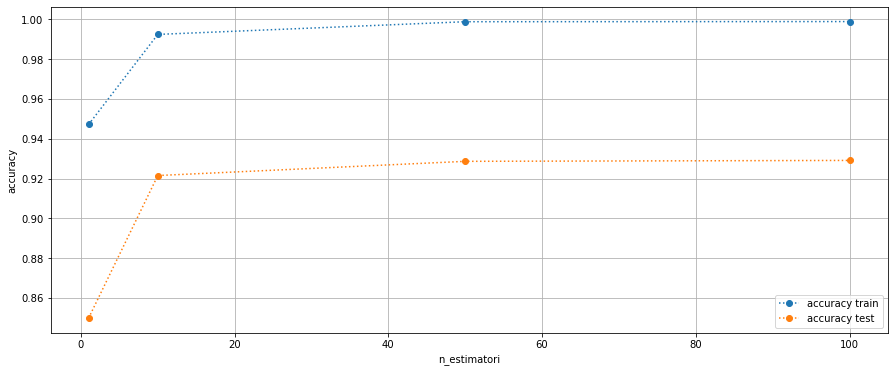

In [101]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(num_est,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(num_est,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('n_estimatori')
ax.grid()
ax.legend()

#### tuning max_depth (deault none)

In [102]:
max_depth = [1, 10, 25, 50, 100, 200]

In [103]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 3)

In [104]:
train_scoreNum

array([[0.66467855, 0.63695342, 0.64438444],
       [0.95423984, 0.85000502, 0.85567114],
       [0.99459413, 0.96682201, 0.9660358 ],
       [0.99976143, 0.99850892, 0.99845469],
       [0.99977227, 0.99850892, 0.99846283],
       [0.99976956, 0.99850078, 0.99846012]])

In [105]:
test_scoreNum

array([[0.63523288, 0.64631918, 0.65727733],
       [0.78005747, 0.92340684, 0.93085686],
       [0.80084043, 0.9925066 , 0.99216501],
       [0.8040449 , 0.99160653, 0.99172581],
       [0.80413165, 0.99159026, 0.99187221],
       [0.80403405, 0.99154688, 0.99172581]])

In [106]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [107]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

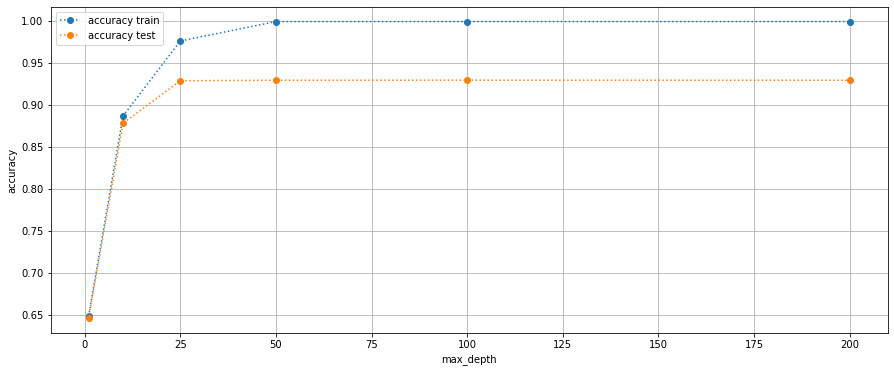

In [108]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(max_depth,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(max_depth,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('max_depth')
ax.grid()
ax.legend()

#### tuning min_samples_split (default = 2)

In [109]:
min_samples_split = [1, 2, 3, 4, 5]

In [110]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, cv = 3)

In [111]:
train_scoreNum

array([[       nan,        nan,        nan],
       [0.99977227, 0.99850349, 0.99846283],
       [0.99955267, 0.99705036, 0.99696361],
       [0.99891286, 0.99307866, 0.99281026],
       [0.99844927, 0.98737729, 0.98729867]])

In [112]:
test_scoreNum

array([[       nan,        nan,        nan],
       [0.80415334, 0.99154146, 0.99187221],
       [0.80374668, 0.99242527, 0.99268553],
       [0.80325869, 0.9930217 , 0.99304882],
       [0.80280323, 0.9932657 , 0.99328197]])

In [113]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [114]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

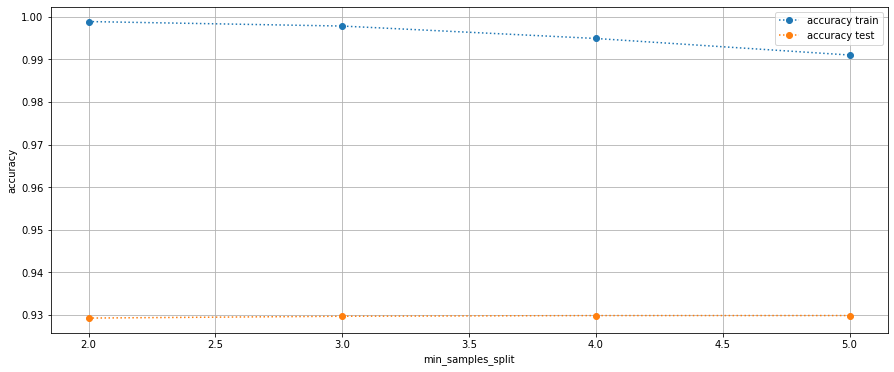

In [115]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_split,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_split,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_split')
ax.grid()
ax.legend()

#### tuning min_samples_leaf (default = 1)

In [116]:
min_samples_leaf = [1, 2, 3, 4, 5]

In [117]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, cv = 3)

In [118]:
train_scoreNum

array([[0.99976685, 0.99849536, 0.99846283],
       [0.99610148, 0.96545021, 0.96550715],
       [0.9940736 , 0.93037448, 0.92972382],
       [0.99288344, 0.91458525, 0.91405117],
       [0.99224905, 0.90756359, 0.90756088]])

In [119]:
test_scoreNum

array([[0.80393103, 0.9914276 , 0.99192101],
       [0.80147481, 0.99310846, 0.99309761],
       [0.80001084, 0.99246322, 0.99211079],
       [0.79928428, 0.99189932, 0.99139506],
       [0.79860652, 0.99144928, 0.99091791]])

In [120]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [121]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

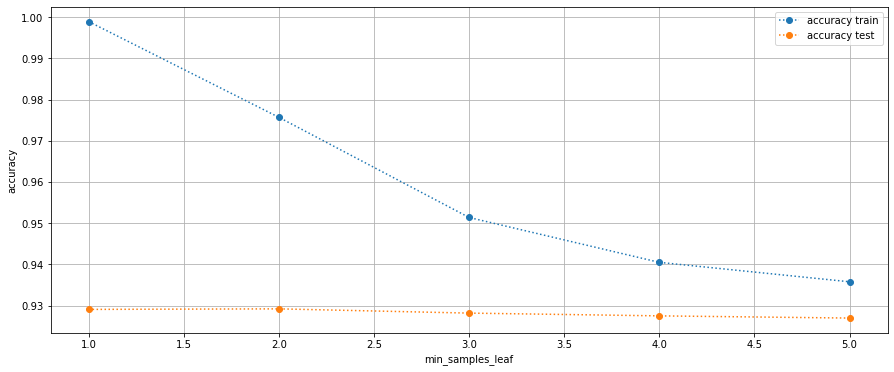

In [122]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(min_samples_leaf,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(min_samples_leaf,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('min_samples_leaf')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del tol (default = 100)

In [123]:
tol = [0.000001, 0.00001, 0.0001, 0.001, 0.01]

In [124]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'tol', 
                                param_range = tol, cv = 3)

In [125]:
train_scoreNum

array([[0.63330875, 0.63196506, 0.63035198],
       [0.63330875, 0.63196506, 0.63035198],
       [0.63330875, 0.63196506, 0.63035198],
       [0.63330875, 0.63196506, 0.63035198],
       [0.63330875, 0.63196506, 0.63035198]])

In [126]:
test_scoreNum

array([[0.628298  , 0.63099621, 0.63456398],
       [0.628298  , 0.63099621, 0.63456398],
       [0.628298  , 0.63099621, 0.63456398],
       [0.628298  , 0.63099621, 0.63456398],
       [0.628298  , 0.63099621, 0.63456398]])

In [127]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [128]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

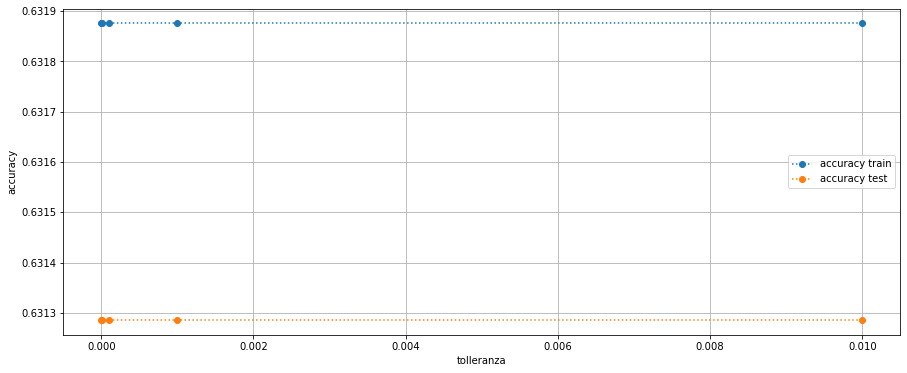

In [129]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(tol,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(tol,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('tolleranza')
ax.grid()
ax.legend()

### Logistic Regressor

#### tuning del C (default = 100)

In [130]:
C = [0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0]

In [131]:
train_scoreNum, test_scoreNum = validation_curve(
                                LogisticRegression(),
                                X = X_train_r365_ov, y = y_train_r365_ov, 
                                param_name = 'C', 
                                param_range = C, cv = 3)

In [132]:
train_scoreNum

array([[0.63330333, 0.63200573, 0.63030318],
       [0.63330062, 0.63201386, 0.63035469],
       [0.63330875, 0.63196506, 0.63035198],
       [0.63330062, 0.63203013, 0.6302842 ],
       [0.63326809, 0.63202741, 0.63026251],
       [0.63334129, 0.63201386, 0.63028149],
       [0.63328164, 0.63199759, 0.63030047]])

In [133]:
test_scoreNum

array([[0.62825462, 0.63088777, 0.63448265],
       [0.628298  , 0.63102332, 0.63460193],
       [0.628298  , 0.63099621, 0.63456398],
       [0.62827631, 0.63095283, 0.63460736],
       [0.62831969, 0.63104501, 0.63454771],
       [0.62833595, 0.63107212, 0.6345694 ],
       [0.62832511, 0.63107754, 0.63454229]])

In [134]:
avg_train_scoreNum = np.average(train_scoreNum, axis=1)

In [135]:
avg_test_scoreNum = np.average(test_scoreNum, axis=1)

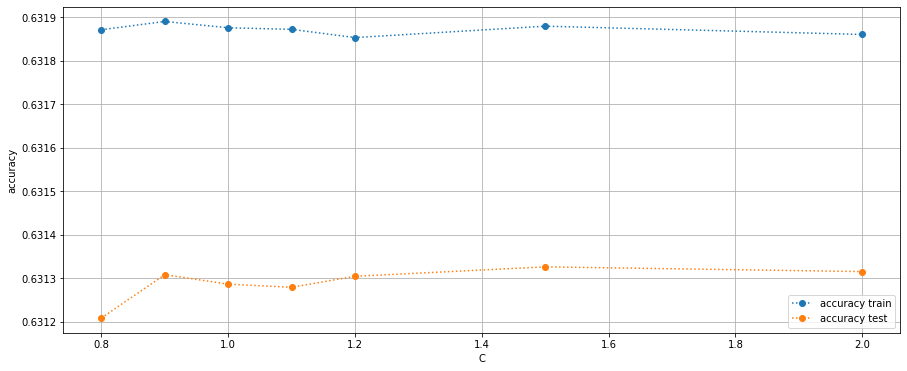

In [136]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(C,avg_train_scoreNum, 'o:', label='accuracy train')
ax.plot(C,avg_test_scoreNum, 'o:', label='accuracy test')
ax.set_ylabel('accuracy')
ax.set_xlabel('C')
ax.grid()
ax.legend()

# Predizioni finali sul test ( modello scelto logistic regressor)
applico il modello scelto al test set

In [137]:
X_test_r365  # il test set mai visto dal modello, che bisogna però scalare

,gender,age,icd_D_blood,icd_D_health_status,icd_D_pregnancy,icd_D_abnormal,icd_D_chromosomal,icd_D_infectious_parasitic,icd_D_musculoskeletal,icd_D_nervous_system,...,ethn__BLACK/AFRICAN AMERICAN,ethn__HISPANIC/LATINO,ethn__OTHER,ethn__UNKNOWN,ethn__WHITE,ins__Medicare,ins__Other,maritalS__MARRIED,maritalS__SINGLE,maritalS__WIDOWED
465869,0,46,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
416293,0,48,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
98968,0,60,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,1,0,0
254219,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0
4251,0,43,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1,84,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,1,0,1,0
365838,1,59,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,0,0
131932,1,57,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,0,1,0
146867,1,33,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,0


In [138]:
y_test_r365  # questi sono i dati su cui verrà calcolato l'accuracy score finale

465869    0
416293    0
98968     0
254219    0
4251      0
         ..
259178    0
365838    0
131932    1
146867    0
121958    0
Name: riad 365d, Length: 156333, dtype: int64

In [139]:
X_test_r365_scaled = scaler.transform(X_test_r365)  # fitting and transforming training set
X_test_r365_scaled

array([[-0.96512577, -0.22152246, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [-0.96512577, -0.1450444 ,  0.96630854, ..., -0.87579316,
        -0.83029661, -0.32124958],
       [-0.96512577,  0.31382392, -0.51700569, ...,  1.14182211,
        -0.83029661, -0.32124958],
       ...,
       [ 1.03613439,  0.19910684, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439, -0.71862981, -0.51700569, ..., -0.87579316,
         1.20438887, -0.32124958],
       [ 1.03613439,  1.15508251,  3.93293702, ..., -0.87579316,
        -0.83029661,  3.11284458]])

In [140]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_r365_ov, y_train_r365_ov)

LogisticRegression(random_state=42)

In [141]:
final_pred_lr = lr.predict(X_test_r365_scaled)
final_pred_lr

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [142]:
acc_lr = accuracy_score(y_test_r365, final_pred_lr)
acc_lr

0.5200309595542848

In [143]:
cm_lr_final = confusion_matrix(y_test_r365, final_pred_lr)
ps_lr_final = precision_score(y_test_r365, final_pred_lr)
rs_lr_final = recall_score(y_test_r365, final_pred_lr)
f1_lr_final = f1_score(y_test_r365, final_pred_lr)

In [144]:
perf_lr_final = {
                   'Metric': ['precision','recall','f1'],
                   'final': [ps_lr_final, rs_lr_final, f1_lr_final]
                 }

In [145]:
table_lr_final = pd.DataFrame(perf_lr_final, columns = ['Metric', 'final'])
table_lr_final.style.set_table_attributes("style='display:inline'").set_caption('LOGISTIC REGRESSOR FINAL PERFORMANCES')

,Metric,final
0,precision,0.157982
1,recall,0.738919
2,f1,0.260309


In [146]:
print("{} veri positivi".format(cm_lr_final[1,1]))
print("{} veri negativi".format(cm_lr_final[0,0]))
print("{} falsi positivi".format(cm_lr_final[0,1]))
print("{} falsi negativi".format(cm_lr_final[1,0]))

13203 veri positivi
68095 veri negativi
70370 falsi positivi
4665 falsi negativi


ancora una volta tra i vari modelli il logistic regressor tende a massimizzare la recall anche se in questo caso è più difficile definire se è preferibile massimizzare la recall e accontentarci su precision e accuracy 